<a href="https://colab.research.google.com/github/vasid99/cs6910-dl/blob/main/Assignment01/Assignment01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Library + Dataset Dependencies

In [ ]:
!pip install -q wandb

     |████████████████████████████████| 2.0MB 12.5MB/s 
     |████████████████████████████████| 163kB 71.7MB/s 
     |████████████████████████████████| 133kB 47.4MB/s 
     |████████████████████████████████| 102kB 8.5MB/s 
     |████████████████████████████████| 71kB 7.8MB/s 


In [ ]:
# imports
import numpy as np
import wandb
from keras.datasets import fashion_mnist, mnist
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.cm as cm

In [ ]:
((x_train, y_train), (x_test, y_test)) = fashion_mnist.load_data()
classes, idx_sample_class = np.unique(y_train, return_index=True)
sample_images = x_train[ idx_sample_class ]

wandb.init()
wandb.log({"Images for each class": [ wandb.Image(sample_images[i], caption="Label:"+str(classes[i])) for i in range(len(idx_sample_class)) ] })

# 2. Neural Network Class Definition

In [ ]:
# function constants
ACTIVATION_SIGMOID   = 'sigmoid'
ACTIVATION_SOFTMAX   = 'softmax'
ACTIVATION_THRESHOLD = 'threshold'
ACTIVATION_RELU      = 'reLU'
ACTIVATION_TANH      = 'tanh'

LOSS_SQERROR         = 'sq_error'
LOSS_CROSSENTROPY    = 'cross_entropy'

GDOPT_NONE           = 'vanilla'
GDOPT_MOMENTUM       = 'momentum'
GDOPT_NESTEROV       = 'NAG'
GDOPT_ADAGRAD        = 'adagrad'
GDOPT_RMSPROP        = 'rmsprop'
GDOPT_ADAM           = 'adam'
GDOPT_NADAM          = 'nadam'

WINIT_RANDOM         = 'random'
WINIT_XAVIER         = 'xavier'

# numerical limits
EXP_INPUT_TOL = 100
'''
def expinbound(x):
  return np.minimum(np.maximum(x,-EXP_INPUT_TOL),EXP_INPUT_TOL) # return np.maximum(x - np.max(x), -300) # 

def expinbound(x):
  return 200*(x - np.mean(x, axis=0))/(np.amax(x, axis=0) - np.amin(x, axis=0)) # return np.maximum(x - np.max(x), -300) # 
'''
def expinbound(x):
  return np.maximum(x - np.amax(x, axis=0) + 300, -300) # 

class neuralNetwork:
  """
  Class for a neural network made up of multiple layers of perceptrons
  """
  def __init__(self,hyperparams):
    """
    Initialize parameters and hyperparameters of neural network
    """
    # assign basic hyperparameters to neural network and math functions object
    self.hyperparams = {}
    self.setHyperparameters(hyperparams)

    # initialize the weight and bias matrices of the NN
    self.initModel(hyperparams)
  
  def setHyperparameters(self,hp):
    """
    Set hyperparameters of neural network
    """
    # change values of only the hyperparameters specified in the input variable
    self.hyperparams.update(hp)
    
    # use member variables for commonly used hyperparameters
    self.layerSizes       = self.hyperparams["layerSizes"]
    self.batchSize        = self.hyperparams["batchSize"]
    self.learningRate     = self.hyperparams["learningRate"]
    self.epochs           = self.hyperparams["epochs"]
    self.numLayers        = len(self.layerSizes) - 1
    
    # set math functions object hyperparameters
    assert len(self.hyperparams["activations"])==self.numLayers, "number of layers (%d) and number of activations (%d) don't match"%(self.numLayers,len(hp["activations"]))
    self.activations = self.hyperparams["activations"]
    self.lossFn = self.hyperparams["lossFn"]
    self.regparam = self.hyperparams["regparam"]

  def initModel(self,hyperparams):
    """
    Initialize parameters (weight and bias matrices) of neural network
    """
    # checking bounds arg
    bounds = (0,1)
    if "initWeightBounds" in hyperparams.keys():
      assert len(hyperparams["initWeightBounds"])==2, "bounds arg has to be a list/tuple of 2 numbers"
      bounds = hyperparams["initWeightBounds"]

    # create list of weight matrices and bias vectors
    # the goal is to make the indexing same as that in lecture derivation, hence the dummy values
    self.wmat = [np.array([1],ndmin=2)]
    self.bias = [np.array([1],ndmin=2)]
    
    # create random initial parameters and append them to the above initialized lists
    for i in range(1,self.numLayers+1):
      if self.hyperparams["initWeightMethod"]==WINIT_XAVIER:
        bounds = (-1/(self.layerSizes[i-1])**0.5,1/(self.layerSizes[i-1])**0.5)
      self.wmat.append((bounds[1]-bounds[0])*np.random.rand(self.layerSizes[i],self.layerSizes[i-1])+bounds[0])
      self.bias.append((bounds[1]-bounds[0])*np.random.rand(self.layerSizes[i],1)+bounds[0])

  def activation(self,layerNum,x):
    """
    Compute and return activation values for a given layer and its sum values
    """
    layerNum -= 1 # index adjustment
    if self.activations[layerNum]==ACTIVATION_SIGMOID:
      out = np.zeros(np.shape(x))
      out[x>100] = 1
      out[(x<=100)&(x>=-100)] = 1/(1 + np.exp(x[(x<=100)&(x>=-100)]))
      return out
    elif self.activations[layerNum]==ACTIVATION_SOFTMAX:
      z = np.exp(expinbound(x))
      return z/np.sum(z,axis=0)
    elif self.activations[layerNum]==ACTIVATION_THRESHOLD:
      return (x>=0)+0
    elif self.activations[layerNum]==ACTIVATION_RELU:
      return np.maximum(x,0)
    elif self.activations[layerNum]==ACTIVATION_TANH:
      return np.tanh(x)
  
  def activationDerivative(self,layerNum,**kwargs):
    """
    Compute and return activation derivative values for a given layer and its sum or output values depending on the given argument
    """
    assert ( len(kwargs.keys())==1 and np.any([_ in kwargs.keys() for _ in ["x","y"]]) ), "activationDerivative argument malformed. \
    Use activationDerivative(layerNum,x=x_val) or activationDerivative(layerNum,y=y_val)"
    layerNum -= 1 # index adjustment
    
    if "y" in kwargs.keys():
      y = kwargs["y"]
      if self.activations[layerNum]==ACTIVATION_SIGMOID:
        return y*(1-y)
      elif self.activations[layerNum]==ACTIVATION_SOFTMAX:
        return y*(1-y)
      elif self.activations[layerNum]==ACTIVATION_THRESHOLD:
        return y*(1-y)
      elif self.activations[layerNum]==ACTIVATION_RELU:
        return (y>=0)+0
      elif self.activations[layerNum]==ACTIVATION_TANH:
        return 1-y**2
    else:
      x = kwargs["x"]
      if self.activations[layerNum]==ACTIVATION_SIGMOID:
        return np.exp(-x)/(1+np.exp(-x))**2
      elif self.activations[layerNum]==ACTIVATION_SOFTMAX:
        z = np.exp(x)
        s = np.sum(z)
        return z*(s-z)/(s**2)
      elif self.activations[layerNum]==ACTIVATION_THRESHOLD:
        return np.exp(-x)/(1+np.exp(-x))**2
      elif self.activations[layerNum]==ACTIVATION_RELU:
        return (x>=0)+0
      elif self.activations[layerNum]==ACTIVATION_RELU:
        return 1-np.tanh(x)**2
  
  def lossOutputDerivative(self,outputData,targetData):
    """
    Compute and return loss derivatives for given output and target data
    """
    if self.lossFn==LOSS_SQERROR:
      return (outputData-targetData) #/len(targetData[0])
    elif self.lossFn==LOSS_CROSSENTROPY:
      outputData = np.maximum(outputData/np.sum(outputData, axis=0), 1e-100)
      ret = targetData.copy()
      ret[targetData==1] = -(1 / outputData[targetData==1]) #/len(targetData[0])
      return ret
  
  def forwardPass(self, inputData):
    """
    Compute output activations of all layers of neural network
    Data can also be given as sets of datapoints (dimensions being layer dimension x dataset size)
    """
    #                                              # --- PSEUDOCODE ---
    h     = inputData                              # h[0] = x
    hData = [h]                                    #
    datasetSize = np.shape(inputData)[1]           #
    #                                              #
    for i in range(1,self.numLayers+1):            # for i from 1 to L:
      a   = self.wmat[i] @ h + self.bias[i]        #     a[i] = w[i] @ h[i-1] + b[i]
      h   = self.activation(i,a)               #     h[i] = f(a[i])
      hData.append(h)
    
    return hData
  
  def backwardPass(self, layerwiseOutputData, targetData):
    """
    Compute weight and bias gradients for all layers of neural network
    Data can also be given as sets of datapoints (dimensions being layer dimension x dataset size)
    """
    #                                                                                        # --- PSEUDOCODE ---
    lossData    = self.lossOutputDerivative(layerwiseOutputData[-1], targetData)             # loss_derivative = d(loss)/dh[L]
    Delta       = lossData                                                                   # Delta[L] = loss_derivative
    datasetSize = np.shape(targetData)[1]                                                    #
    biasInputs  = np.array(np.ones(datasetSize),ndmin=2).T                                   #
    gradW       = []                                                                         #
    gradB       = []                                                                         #
    #                                                                                        #
    for iFwd in range(self.numLayers):                                                       # for i from L to 1:
      i            = self.numLayers - iFwd                                                   #     // index correction
      stocBiasCorr = self.activationDerivative(i,y=layerwiseOutputData[i]) * Delta           #     stochastic_bias_corrections = f'(a[i]) * Delta[i]
      gW           = stocBiasCorr @ layerwiseOutputData[i-1].T + self.regparam*self.wmat[i] #/len(targetData[0])  #     grad(W[i]) = stochastic_bias_corrections x (h[i-1]).T
      gB           = stocBiasCorr @ biasInputs + self.regparam*self.bias[i] #/len(targetData[0])                              #     grad(b[i]) = sum(stochastic_bias_corrections)
      Delta        = self.wmat[i].T @ stocBiasCorr                                           #     Delta[i-1] = W[i] x stochastic_bias_corrections
      
      gradW.append(gW)
      '''
      f=open("wout.txt","a")
      f.write(str(gW))
      f.write(str(gB))
      f.close()
      '''
      gradB.append(gB)
    
    # dummy element and order handling
    gradW.append(np.array([0],ndmin=2))
    gradW.reverse()
    gradB.append(np.array([0],ndmin=2))
    gradB.reverse()
    
    return (gradW,gradB)
  
  def infer(self,inputData,**kwargs):
    """
    Perform inference on input dataset using the neural network
    Unless colwiseData=True is given as an argument, data will be interpreted as being dataset size x layer dimension
    """
    # resolving input dimensions
    inputData  = np.array(inputData,ndmin=2)
    if "colwiseData" in kwargs and kwargs["colwiseData"]==True:
      pass
    else:
      inputData  = inputData.T
    assert np.shape(inputData)[0]==self.layerSizes[0], "size of input datapoint differs from size of input vector given as hyperparameter"
    
    # perform forward pass and return last-layer outputs
    return self.forwardPass(inputData)[-1]

  def gradtheta_for_batchindex(self, inputData, targetData, datasetSize, batchSize, numBatches, batchIndex):##
    # create data batches
    startIndex  = batchSize * batchIndex
    endIndex    = min(startIndex + batchSize, datasetSize)
    inputBatch  = inputData[:,startIndex:endIndex]
    targetBatch = targetData[:,startIndex:endIndex]
    # perform forward and backward passes to compute gradients
    layerwiseOutputData = self.forwardPass(inputBatch)
    (gradW, gradB)      = self.backwardPass(layerwiseOutputData,targetBatch)
    return gradW, gradB ##

  def update_val_train_loss_and_acc(self, inputData, targetData, x_val, y_val, epoch):
    TOL = 1e-300
    y_pred_train = self.infer(inputData, colwiseData =True)
    y_pred_val   = self.infer(x_val, colwiseData =True)
    #print(y_pred_train[:,:4]-targetData[:,:4])
    modW_sq = np.sum( np.array( [ np.linalg.norm(W)**2 for W in self.wmat ] ) )
    modB_sq = np.sum( np.array( [ np.linalg.norm(B)**2 for B in self.bias ] ) )
    modtheta_sq = (modW_sq + modB_sq)
    if self.lossFn==LOSS_SQERROR:
      loss_train = (0.5*np.sum(np.linalg.norm(y_pred_train - targetData, axis=0)**2) + 0.5*self.regparam*modtheta_sq) #/len(targetData[0])
      loss_val   = (0.5*np.sum(np.linalg.norm(  y_pred_val - y_val     , axis=0)**2) + 0.5*self.regparam*modtheta_sq) #/len(y_val[0])
    elif self.lossFn==LOSS_CROSSENTROPY:
      loss_train = - np.sum(targetData * np.log( np.maximum(y_pred_train, TOL)))/len(targetData[0]) + 0.5*self.regparam*modtheta_sq
      loss_val   = - np.sum(     y_val * np.log( np.maximum(y_pred_val, TOL)  ))/len(y_val[0]) + 0.5*self.regparam*modtheta_sq
    acc_train = np.count_nonzero( np.argmax(targetData, axis=0) == np.argmax(y_pred_train, axis=0) )/len(targetData[0])
    acc_val   = np.count_nonzero( np.argmax(     y_val, axis=0) == np.argmax(  y_pred_val, axis=0) )/len(y_val[0])
    self.loss_train.append(loss_train)
    self.acc_train.append(acc_train)
    self.loss_val.append(loss_val)
    self.acc_val.append(acc_val)
    wandb.log({"loss_train":self.loss_train[-1],"acc_train":self.acc_train[-1],
               "loss_val":self.loss_val[-1],"acc_val":self.acc_val[-1], "epoch": epoch}) #,"weightDump":wandb.Html(str(self.wmat))

  def sgd(self, inputData, targetData, datasetSize, batchSize, numBatches, x_val, y_val):
    # run training loop
    for epoch in range(self.epochs):
      self.update_val_train_loss_and_acc(inputData, targetData, x_val, y_val, epoch)
      for batchIndex in range(numBatches):       
        #Get grad theta
        (gradW, gradB) = self.gradtheta_for_batchindex(inputData, targetData, datasetSize, batchSize, numBatches, batchIndex) ##
        # perform parameter update
        for i in range(1,self.numLayers+1):
          self.wmat[i] += -self.learningRate * gradW[i]
          self.bias[i] += -self.learningRate * gradB[i]
    self.update_val_train_loss_and_acc(inputData, targetData, x_val, y_val, epoch+1)

  def momentumGD(self, inputData, targetData, datasetSize, batchSize, numBatches, x_val, y_val):
    eta = self.learningRate
    gamma = self.hyperparams["beta_1"]
    #initialize
    self.loss_lst_train = [] ##
    self.acc_lst_train = [] ##
    update_w = [0]*(self.numLayers+1)
    update_b = [0]*(self.numLayers+1)
    # run training loop
    for epoch in range(self.epochs):
      self.update_val_train_loss_and_acc(inputData, targetData, x_val, y_val, epoch)
      for batchIndex in range(numBatches):       
        #Get grad theta
        (gradW, gradB) = self.gradtheta_for_batchindex(inputData, targetData, datasetSize, batchSize, numBatches, batchIndex) ##
        # perform parameter update
        for i in range(1,self.numLayers+1):
          update_w[i] = gamma*update_w[i] + eta*gradW[i]
          update_b[i] = gamma*update_b[i] + eta*gradB[i]
          self.wmat[i] += -update_w[i]
          self.bias[i] += -update_b[i]
    self.update_val_train_loss_and_acc(inputData, targetData, x_val, y_val, epoch+1) 

  def NAG(self, inputData, targetData, datasetSize, batchSize, numBatches, x_val, y_val):
    eta = self.learningRate
    gamma = self.hyperparams["beta_1"]
    #initialize
    update_w = [0]*(self.numLayers+1)
    update_b = [0]*(self.numLayers+1)
    # run training loop
    for epoch in range(self.epochs):
      self.update_val_train_loss_and_acc(inputData, targetData, x_val, y_val, epoch)
      for batchIndex in range(numBatches):
        # perform look ahead parameter update
        for i in range(1,self.numLayers+1):
          self.wmat[i] += -gamma*update_w[i]
          self.bias[i] += -gamma*update_b[i]
        (gradW, gradB) = self.gradtheta_for_batchindex(inputData, targetData, datasetSize, batchSize, numBatches, batchIndex) ##
        # perform parameter update
        for i in range(1,self.numLayers+1):
          update_w[i] = gamma*update_w[i] + eta*gradW[i]
          update_b[i] = gamma*update_b[i] + eta*gradB[i]
          self.wmat[i] += -eta*gradW[i]
          self.bias[i] += -eta*gradB[i]
    self.update_val_train_loss_and_acc(inputData, targetData, x_val, y_val, epoch+1) 

  def rmsprop(self, inputData, targetData, datasetSize, batchSize, numBatches, x_val, y_val):
    eta = self.learningRate
    beta = self.hyperparams["beta_2"]
    epsilon = self.hyperparams["epsilon"]
    #Initialise
    v_w = [0]*(self.numLayers+1)
    v_b = [0]*(self.numLayers+1)
    # run training loop
    for epoch in range(self.epochs):
      self.update_val_train_loss_and_acc(inputData, targetData, x_val, y_val, epoch)
      for batchIndex in range(numBatches):        
        (gradW, gradB) = self.gradtheta_for_batchindex(inputData, targetData, datasetSize, batchSize, numBatches, batchIndex) ##
        # perform parameter update
        for i in range(1,self.numLayers+1):
          v_w[i] = beta*v_w[i] + (1-beta)*gradW[i]**2
          v_b[i] = beta*v_b[i] + (1-beta)*gradB[i]**2 
          self.wmat[i] += -eta * (v_w[i] + epsilon)**-0.5 * gradW[i]
          self.bias[i] += -eta * (v_b[i] + epsilon)**-0.5 * gradB[i]
    self.update_val_train_loss_and_acc(inputData, targetData, x_val, y_val, epoch+1) 
  
  def adam(self, inputData, targetData, datasetSize, batchSize, numBatches, x_val, y_val):
    eta = self.learningRate
    beta_1 = self.hyperparams["beta_1"]
    beta_2 = self.hyperparams["beta_2"]
    epsilon = self.hyperparams["epsilon"]
    #initialize
    m_w = [0]*(self.numLayers+1)
    m_b = [0]*(self.numLayers+1)
    v_w = [0]*(self.numLayers+1)
    v_b = [0]*(self.numLayers+1)
    t = 1 #tracks the iteration number
    # run training loop
    for epoch in range(self.epochs):
      self.update_val_train_loss_and_acc(inputData, targetData, x_val, y_val, epoch)
      for batchIndex in range(numBatches): 
        (gradW, gradB) = self.gradtheta_for_batchindex(inputData, targetData, datasetSize, batchSize, numBatches, batchIndex) ##
        # perform parameter update
        for i in range(1,self.numLayers+1):
          m_w[i] = beta_1*m_w[i] + (1-beta_1)*gradW[i]
          m_b[i] = beta_1*m_b[i] + (1-beta_1)*gradB[i]
          v_w[i] = beta_2*v_w[i] + (1-beta_2)*gradW[i]**2
          v_b[i] = beta_2*v_b[i] + (1-beta_2)*gradB[i]**2
          m_w_hat = m_w[i]/(1-beta_1**t)
          m_b_hat = m_b[i]/(1-beta_1**t)
          v_w_hat = v_w[i]/(1-beta_2**t)
          v_b_hat = v_b[i]/(1-beta_2**t)
          self.wmat[i] += -eta * (v_w_hat + epsilon)**-0.5 * m_w_hat
          self.bias[i] += -eta * (v_b_hat + epsilon)**-0.5 * m_b_hat
        t += 1
    self.update_val_train_loss_and_acc(inputData, targetData, x_val, y_val, epoch+1) 

  def nadam(self, inputData, targetData, datasetSize, batchSize, numBatches, x_val, y_val):
    eta = self.learningRate
    beta_1 = self.hyperparams["beta_1"]
    beta_2 = self.hyperparams["beta_2"]
    epsilon = self.hyperparams["epsilon"]
    #initialize
    m_w = [0]*(self.numLayers+1)
    m_b = [0]*(self.numLayers+1)
    v_w = [0]*(self.numLayers+1)
    v_b = [0]*(self.numLayers+1)
    t = 1 #tracks the iteration number
    # run training loop
    for epoch in range(self.epochs):
      self.update_val_train_loss_and_acc(inputData, targetData, x_val, y_val, epoch)
      for batchIndex in range(numBatches): 
        (gradW, gradB) = self.gradtheta_for_batchindex(inputData, targetData, datasetSize, batchSize, numBatches, batchIndex) ##
        # perform parameter update
        for i in range(1,self.numLayers+1):
          m_w[i] = beta_1*m_w[i] + (1-beta_1)*gradW[i]
          m_b[i] = beta_1*m_b[i] + (1-beta_1)*gradB[i]
          v_w[i] = beta_2*v_w[i] + (1-beta_2)*gradW[i]**2
          v_b[i] = beta_2*v_b[i] + (1-beta_2)*gradB[i]**2
          m_w_hat = (beta_1/(1-beta_1**(t+1)))*m_w[i] + ((1-beta_1)/(1-beta_1**t))*gradW[i]
          m_b_hat = (beta_1/(1-beta_1**(t+1)))*m_b[i] + ((1-beta_1)/(1-beta_1**t))*gradB[i]
          v_w_hat = v_w[i]/(1-beta_2**t)
          v_b_hat = v_b[i]/(1-beta_2**t)
          self.wmat[i] += -eta * (v_w_hat + epsilon)**-0.5 * m_w_hat
          self.bias[i] += -eta * (v_b_hat + epsilon)**-0.5 * m_b_hat
        t += 1
    self.update_val_train_loss_and_acc(inputData, targetData, x_val, y_val, epoch+1) 


  def train(self, inputData, targetData, x_val, y_val, **kwargs):
    """
    Train the network on the given input and target datasets
    Unless colwiseData=True is given as an argument, data will be interpreted as being dataset size x layer dimension
    """
    # resolving input and target dimensions
    inputData  = np.array(inputData,ndmin=2)
    targetData = np.array(targetData,ndmin=2)
    if "colwiseData" in kwargs and kwargs["colwiseData"]==True:
      pass
    else:
      inputData  = inputData.T
      targetData = targetData.T
      x_val = x_val.T
      y_val = y_val.T
    assert np.shape(inputData)[1]==np.shape(targetData)[1], "input and target datasets have different dataset sizes"
    assert np.shape(inputData)[0]==self.layerSizes[0], "size of input datapoint differs from size of input vector given as hyperparameter"
    assert np.shape(targetData)[0]==self.layerSizes[-1], "size of target datapoint differs from size of target vector given as hyperparameter"
    datasetSize = np.shape(targetData)[1]

    # calculate batch parameters
    batchSize = datasetSize if self.batchSize==-1 else self.batchSize
    numBatches = int(np.ceil(datasetSize / batchSize))

    #Initialise loss and accuracy lists
    self.loss_train = []
    self.acc_train = []
    self.loss_val = []
    self.acc_val = []

    if self.hyperparams["optimizer"] == GDOPT_NONE:
      self.sgd(inputData, targetData, datasetSize, batchSize, numBatches, x_val, y_val)
    elif self.hyperparams["optimizer"] == GDOPT_MOMENTUM:
      self.momentumGD(inputData, targetData, datasetSize, batchSize, numBatches, x_val, y_val)
    elif self.hyperparams["optimizer"] == GDOPT_NESTEROV:
      self.NAG(inputData, targetData, datasetSize, batchSize, numBatches, x_val, y_val)
    elif self.hyperparams["optimizer"] == GDOPT_RMSPROP:
      self.rmsprop(inputData, targetData, datasetSize, batchSize, numBatches, x_val, y_val)
    elif self.hyperparams["optimizer"] == GDOPT_ADAM:
      self.adam(inputData, targetData, datasetSize, batchSize, numBatches, x_val, y_val)
    elif self.hyperparams["optimizer"] == GDOPT_NADAM:
      self.nadam(inputData, targetData, datasetSize, batchSize, numBatches, x_val, y_val)
    
    self.loss_train = np.array(self.loss_train)
    self.acc_train = np.array(self.acc_train)
    self.loss_val = np.array(self.loss_val)
    self.acc_val = np.array(self.acc_val)

        
        

# 3. Fashion-MNIST Data Initialization and Reshaping

In [ ]:
((x_train, y_train), (x_test, y_test)) = fashion_mnist.load_data()
classes, idx_sample_class = np.unique(y_train, return_index=True)
sample_images = x_train[ idx_sample_class ]

#Reshaping the 'x' data:
len_1D = x_train.shape[1]*x_train.shape[2]
x_train_1D = np.array( [x.reshape(len_1D) for x in x_train] )
x_test_1D  = np.array( [x.reshape(len_1D) for x in x_test] )

#Transforming 'y' data - changing scalar i to vector e(i)
y_train_1D = np.zeros( (len(y_train), len(classes)) )
for i in range(len(y_train)):
  y_train_1D[i, y_train[i]] = 1
y_test_1D = np.zeros( (len(y_test), len(classes)) )
for i in range(len(y_test)):
  y_test_1D[i, y_test[i]] = 1

y_train_1D = y_train_1D.astype(float)
y_test_1D = y_test_1D.astype(float)

frac_val = 0.1
all_idx = np.arange(len(x_train))
val_idx = np.random.choice(all_idx, int(frac_val*len(x_train)), replace=False)
tr2_idx = np.array([i for i in all_idx if i not in val_idx])

x_train2 = x_train_1D[tr2_idx]
y_train2 = y_train_1D[tr2_idx]
x_val = x_train_1D[val_idx]
y_val = y_train_1D[val_idx]

# 4. Runs

In [ ]:
# Sample Run
'''wandb.init()
hyp = {
    "layerSizes": [len(x_train_1D[0]),100,len(y_train_1D[0])],
    "batchSize": 128,
    "learningRate": 1e-6,
    "epochs": 10000,
    "activations": [ ACTIVATION_RELU, ACTIVATION_SOFTMAX ],
    "lossFn": LOSS_CROSSENTROPY,
    "initWeightBounds": (-1,1),
    "initWeightMethod": WINIT_XAVIER,
    "optimizer": GDOPT_ADAM,
    "beta_1": 0.9,   # momentum scaling hyperparam
    "beta_2": 0.999, # eta scaling hyperparam
    "epsilon": 1e-3,  # eta scaling hyperparam
    "regparam": 0
}

NN = neuralNetwork(hyp)
NN.train(x_train2[:101]/(255), y_train2[:101], x_val[0:2]/(255), y_val[0:2])
# Note that x_val, y_val are given as an input just to calculate the loss and error at each epoch.
# They are not used anywhere to train the neural network'''

# 5. Sweeps

In [ ]:
def runSweep():
  wandb.init()
  
  hyp = {}
  cfg = wandb.config

  hyp["epochs"] = cfg.epochs

  layersHidden = []
  for i in range(cfg.numHiddenLayers):
    layersHidden.append(cfg.hiddenLayerSize)
  hyp["layerSizes"] = [len(x_train_1D[0])] + layersHidden + [len(y_train_1D[0])]

  hyp["regparam"] = cfg.L2Reg

  hyp["learningRate"] = cfg.learningRate

  hyp["optimizer"] = cfg.optimizer

  hyp["batchSize"] = cfg.batchSize

  hyp["initWeightMethod"] = cfg.initWeightMethod

  hyp["activations"] = []
  for i in range(cfg.numHiddenLayers):
    hyp["activations"].append(cfg.activationFn)
  hyp["activations"].append(ACTIVATION_SOFTMAX)

  hyp["lossFn"] = cfg.loss

  hyp.update({
    "beta_1": 0.9,   # momentum scaling hyperparam
    "beta_2": 0.999, # eta scaling hyperparam
    "epsilon": 1e-8,  # eta scaling hyperparam
    })

  run_name = wandb.run.name
  wandb.run.name = run_name+'ep_'+str(hyp["epochs"])+'_numhl_'+str(cfg.numHiddenLayers)\
  +'_hlsize_'+str(cfg.hiddenLayerSize)+'_l2reg_'+str(hyp["regparam"])\
  +'_eta_'+str(hyp["learningRate"])+'_'+str(hyp["optimizer"])\
  +'_bs_'+str(hyp["batchSize"])+'_'+str(hyp["initWeightMethod"])+'_'+str(hyp["lossFn"]) 
  wandb.run.save()

  nn = neuralNetwork(hyp)
  nn.train(x_train2/255, y_train2, x_val/255, y_val)

sweepCfg = {
    "name":"NN Fashion MNIST - Test Sweep9", 
    "metric":{
        "name":"acc_val",
        "goal":"maximize"
    }, 
    "method": "bayes", 
    "parameters":{
        "epochs":{
          "values":[25]
        },
        "numHiddenLayers":{
          "values":[3,4,5]
        },
        "hiddenLayerSize":{
          "values":[32,64,128]
        },
        "L2Reg":{
          "values":[0,5e-4,0.5]
        },
        "learningRate":{
          "values":[1e-3, 1e-5, 1e-7]
        },
        "optimizer":{
          "values":[GDOPT_NONE, GDOPT_MOMENTUM, GDOPT_NESTEROV, GDOPT_RMSPROP, GDOPT_ADAM, GDOPT_NADAM]
        },
        "batchSize":{
          "values":[32,64,128]
        },
        "initWeightMethod":{
          "values":[WINIT_RANDOM, WINIT_XAVIER]
        },
        "activationFn":{
          "values":[ACTIVATION_SIGMOID, ACTIVATION_RELU, ACTIVATION_TANH]
        },
        "loss":{
          "values": [LOSS_CROSSENTROPY, LOSS_SQERROR]
        },
    }
}

sweepId = wandb.sweep(sweepCfg)
wandb.agent(sweepId, function = runSweep)

# 6. Confusion Matrix

In [ ]:
wandb.init(project="Test run - 1")
hyp = {
    "layerSizes": [len(x_train_1D[0]),32, 32, 32, 32, 32,len(y_train_1D[0])],
    "batchSize": 128,
    "learningRate": 1e-3,
    "epochs": 30,
    "activations": [ ACTIVATION_TANH, ACTIVATION_TANH, ACTIVATION_TANH, ACTIVATION_TANH, ACTIVATION_TANH, ACTIVATION_SOFTMAX ],
    "lossFn": LOSS_SQERROR, #LOSS_CROSSENTROPY LOSS_SQERROR
    "initWeightBounds": (-1,1),
    "initWeightMethod": WINIT_XAVIER,
    "optimizer": GDOPT_ADAM,
    "beta_1": 0.9,   # momentum scaling hyperparam
    "beta_2": 0.999, # eta scaling hyperparam
    "epsilon": 1e-3,  # eta scaling hyperparam
    "regparam": 5e-4
}

#wandb.config.update(hyp)

NN = neuralNetwork(hyp)
NN.train(x_train_1D/(255), y_train_1D, x_test_1D/(255), y_test_1D)
# Note that x_val, y_val are given as an input just to calculate the loss and error at each epoch.
# They are not used anywhere to train the neural network

In [ ]:
y_pred_1D = NN.infer(x_test_1D/(255))
y_pred = np.argmax(y_pred_1D, axis=0)
conf_mat = confusion_matrix(y_test, y_pred)

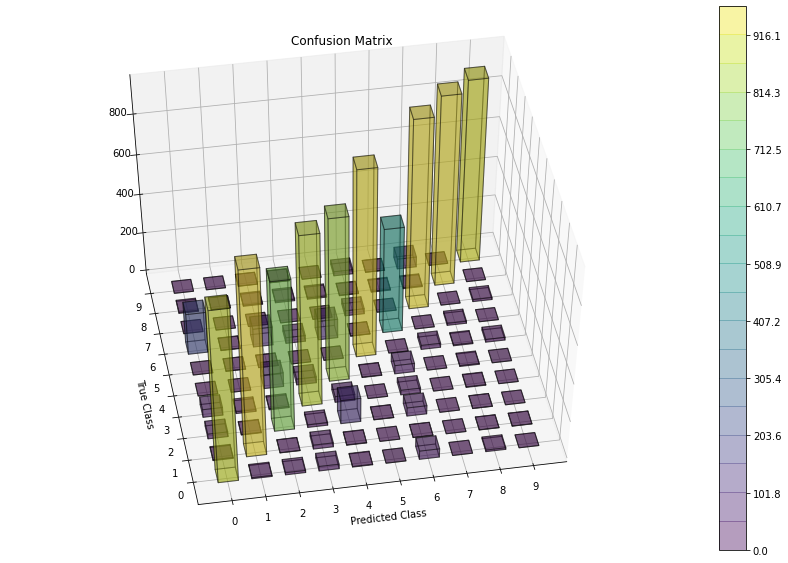

In [ ]:
X, Y = np.meshgrid( np.arange(len(classes))-0.3, np.arange(len(classes))-0.3 )
x_vec = X.ravel()
y_vec = Y.ravel()
z_vec = 0

dx = 0.6*np.ones_like(x_vec)
dy = 0.6*np.ones_like(y_vec)
dz = conf_mat.ravel()

%matplotlib inline

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')

minima = np.amin(conf_mat)
maxima = np.amax(conf_mat)

norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.viridis)

color_vec = [ mapper.to_rgba(v) for v_vec in conf_mat for v in v_vec]

bar3d = ax.bar3d(x_vec, y_vec, z_vec, dx, dy, dz,
         zsort='average', color=color_vec, shade=True,alpha=0.4, edgecolor='black')
ax.set_xlabel('Predicted Class')
ax.set_ylabel('True Class')
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
ax.set_title('Confusion Matrix')
ax.view_init(50,-100)

fig.colorbar(bar3d, boundaries=np.linspace(np.amin(dz), np.amax(dz), 20 ))

plt.show()

In [ ]:
wandb.log({"Confusion Matrix": wandb.Image(fig)})

# 7. Three Best Runs from Fashion-MNIST on MNIST Dataset


In [ ]:
((x_train, y_train), (x_test, y_test)) = mnist.load_data()
classes, idx_sample_class = np.unique(y_train, return_index=True)
sample_images = x_train[ idx_sample_class ]

#Reshaping the 'x' data:
len_1D = x_train.shape[1]*x_train.shape[2]
x_train_1D = np.array( [x.reshape(len_1D) for x in x_train] )
x_test_1D  = np.array( [x.reshape(len_1D) for x in x_test] )

#Transforming 'y' data - changing scalar i to vector e(i)
y_train_1D = np.zeros( (len(y_train), len(classes)) )
for i in range(len(y_train)):
  y_train_1D[i, y_train[i]] = 1
y_test_1D = np.zeros( (len(y_test), len(classes)) )
for i in range(len(y_test)):
  y_test_1D[i, y_test[i]] = 1

y_train_1D = y_train_1D.astype(float)
y_test_1D = y_test_1D.astype(float)

frac_val = 0.1
all_idx = np.arange(len(x_train))
val_idx = np.random.choice(all_idx, int(frac_val*len(x_train)), replace=False)
tr2_idx = np.array([i for i in all_idx if i not in val_idx])

x_train2 = x_train_1D[tr2_idx]
y_train2 = y_train_1D[tr2_idx]
x_val = x_train_1D[val_idx]
y_val = y_train_1D[val_idx]

In [ ]:
def fullMNISTHarness(hyp):
  wandb.init()

  NN = neuralNetwork(hyp)
  NN.train(x_train_1D/(255), y_train_1D, x_test_1D/(255), y_test_1D)

In [ ]:
hyps = []

# Best of top 3
hyps.append({
    "layerSizes": [len(x_train_1D[0]),128, 128, 128, 128, 128,len(y_train_1D[0])],
    "batchSize": 64,
    "learningRate": 1e-3,
    "epochs": 30,
    "activations": [ ACTIVATION_TANH, ACTIVATION_TANH, ACTIVATION_TANH, ACTIVATION_TANH, ACTIVATION_TANH, ACTIVATION_SOFTMAX ],
    "lossFn": LOSS_SQERROR, #LOSS_CROSSENTROPY LOSS_SQERROR
    "initWeightBounds": (-1,1),
    "initWeightMethod": WINIT_XAVIER,
    "optimizer": GDOPT_ADAM,
    "beta_1": 0.9,   # momentum scaling hyperparam
    "beta_2": 0.999, # eta scaling hyperparam
    "epsilon": 1e-3,  # eta scaling hyperparam
    "regparam": 5e-4
})

# Second best of top 3
hyps.append({
    "layerSizes": [len(x_train_1D[0]),128, 128, 128,len(y_train_1D[0])],
    "batchSize": 128,
    "learningRate": 1e-3,
    "epochs": 30,
    "activations": [ ACTIVATION_TANH, ACTIVATION_TANH, ACTIVATION_TANH, ACTIVATION_SOFTMAX ],
    "lossFn": LOSS_SQERROR, #LOSS_CROSSENTROPY LOSS_SQERROR
    "initWeightBounds": (-1,1),
    "initWeightMethod": WINIT_XAVIER,
    "optimizer": GDOPT_ADAM,
    "beta_1": 0.9,   # momentum scaling hyperparam
    "beta_2": 0.999, # eta scaling hyperparam
    "epsilon": 1e-3,  # eta scaling hyperparam
    "regparam": 0
})

# Third best of top 3
hyps.append({
    "layerSizes": [len(x_train_1D[0]),128, 128, 128, 128,len(y_train_1D[0])],
    "batchSize": 64,
    "learningRate": 1e-3,
    "epochs": 30,
    "activations": [ ACTIVATION_TANH, ACTIVATION_TANH, ACTIVATION_TANH, ACTIVATION_TANH, ACTIVATION_SOFTMAX ],
    "lossFn": LOSS_SQERROR, #LOSS_CROSSENTROPY LOSS_SQERROR
    "initWeightBounds": (-1,1),
    "initWeightMethod": WINIT_XAVIER,
    "optimizer": GDOPT_RMSPROP,
    "beta_1": 0.9,   # momentum scaling hyperparam
    "beta_2": 0.999, # eta scaling hyperparam
    "epsilon": 1e-3,  # eta scaling hyperparam
    "regparam": 0
})

# run top 3 configs
for hyp in hyps:
  fullMNISTHarness(hyp)